<a href="https://colab.research.google.com/github/ChangeEngine/Intro-to-ML--Group-1--Final-Project/blob/main/notebooks/02_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import sys


REPO_URL = "https://github.com/ChangeEngine/Intro-to-ML--Group-1--Final-Project.git"
REPO_DIR = Path("/content/Intro-to-ML--Group-1--Final-Project")

if "google.colab" in sys.modules:
    # Running in Google Colab
    if not REPO_DIR.exists():
        !git clone $REPO_URL $REPO_DIR
    os.chdir(REPO_DIR)

print("Working directory:", Path.cwd())




Cloning into '/content/Intro-to-ML--Group-1--Final-Project'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 12.61 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Working directory: /content/Intro-to-ML--Group-1--Final-Project


In [3]:
from pathlib import Path

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    alt = Path("..") / "data"
    if alt.exists():
        DATA_DIR = alt
    else:
        raise FileNotFoundError(
            "Could not find data/ folder at ./data or ../data. "
            "Make sure the repo has a data/ directory with the MNIST .gz files."
        )

print("Using data folder:", DATA_DIR.resolve())
print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)


Using data folder: /content/Intro-to-ML--Group-1--Final-Project/data
Files in data/:
 - train-labels.idx1-ubyte.gz
 - t10k-labels.idx1-ubyte.gz
 - train-images.idx3-ubyte.gz
 - t10k-images.idx3-ubyte.gz


In [5]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

plt.rcParams["figure.figsize"] = (4, 4)


train_images_path = DATA_DIR / "train-images.idx3-ubyte.gz"
train_labels_path = DATA_DIR / "train-labels.idx1-ubyte.gz"
test_images_path  = DATA_DIR / "t10k-images.idx3-ubyte.gz"
test_labels_path  = DATA_DIR / "t10k-labels.idx1-ubyte.gz"

(train_images_path, train_labels_path, test_images_path, test_labels_path)


(PosixPath('data/train-images.idx3-ubyte.gz'),
 PosixPath('data/train-labels.idx1-ubyte.gz'),
 PosixPath('data/t10k-images.idx3-ubyte.gz'),
 PosixPath('data/t10k-labels.idx1-ubyte.gz'))

In [6]:
def load_mnist_images(path):
    """Load MNIST images from an idx3-ubyte.gz file."""
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:16], dtype=">i4")
    magic, num_images, rows, cols = header
    assert magic == 2051, "Not an images file"

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images


def load_mnist_labels(path):
    """Load MNIST labels from an idx1-ubyte.gz file."""
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:8], dtype=">i4")
    magic, num_labels = header
    assert magic == 2049, "Not a labels file"

    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels


def load_mnist_dataset(images_path, labels_path, normalize=True):
    X = load_mnist_images(images_path)
    Y = load_mnist_labels(labels_path)

    if normalize:
        X = X.astype("float32") / 255.0

    return X, Y


In [7]:
X_train, y_train = load_mnist_dataset(train_images_path, train_labels_path)
X_test, y_test   = load_mnist_dataset(test_images_path, test_labels_path)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_test :", y_test.shape, y_test.dtype)

# Flatten 28x28 -> 784 features
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat :", X_test_flat.shape)


X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
X_test : (10000, 28, 28) float32
y_test : (10000,) uint8
X_train_flat: (60000, 784)
X_test_flat : (10000, 784)


In [8]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_flat,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train subset:", X_tr.shape, y_tr.shape)
print("Val subset  :", X_val.shape, y_val.shape)


Train subset: (48000, 784) (48000,)
Val subset  : (12000, 784) (12000,)


In [9]:
subset_size = 20000

X_tr_sub = X_tr[:subset_size]
y_tr_sub = y_tr[:subset_size]

log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=100,
    verbose=1,
)

print("Training Logistic Regression on", X_tr_sub.shape[0], "samples...")
log_reg.fit(X_tr_sub, y_tr_sub)
print("Done.")


Training Logistic Regression on 20000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


max_iter reached after 101 seconds
Done.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


In [10]:
# Validation
y_val_pred = log_reg.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average="macro")
val_f1_weighted = f1_score(y_val, y_val_pred, average="weighted")

print("VALIDATION RESULTS")
print("Accuracy      :", val_acc)
print("F1 (macro)    :", val_f1_macro)
print("F1 (weighted) :", val_f1_weighted)
print("\nClassification report (validation):\n")
print(classification_report(y_val, y_val_pred))

# Test
y_test_pred = log_reg.predict(X_test_flat)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

print("\nTEST RESULTS")
print("Accuracy      :", test_acc)
print("F1 (macro)    :", test_f1_macro)
print("F1 (weighted) :", test_f1_weighted)


VALIDATION RESULTS
Accuracy      : 0.9118333333333334
F1 (macro)    : 0.9106921337212934
F1 (weighted) : 0.9116812400086713

Classification report (validation):

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1185
           1       0.94      0.97      0.96      1348
           2       0.90      0.88      0.89      1192
           3       0.89      0.88      0.88      1226
           4       0.92      0.91      0.91      1168
           5       0.87      0.87      0.87      1084
           6       0.94      0.95      0.94      1184
           7       0.94      0.92      0.93      1253
           8       0.87      0.86      0.87      1170
           9       0.88      0.91      0.89      1190

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000


TEST RESULTS
Accuracy      : 0.9162
F1 (macro)    : 0.9149341532687671
F1 (wei

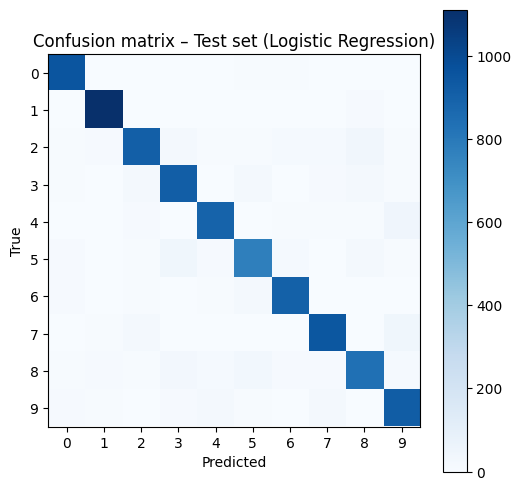

In [11]:
import numpy as np

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix – Test set (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
